# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

## Инструкции

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [210]:
import pickle
import pandas as pd
import numpy as np
import warnings

from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder

from category_encoders.binary import BinaryEncoder
from category_encoders.backward_difference import BackwardDifferenceEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.hashing import HashingEncoder

from sklearn.svm import LinearSVC
from sklearn.model_selection import validation_curve
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from itertools import product

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
PATH_TO_DATA = r"C:\Users\preductor\Documents\MachineLearning\6_course\Сhurn_prediction\week_4"

In [211]:
raw_data = pd.read_csv(PATH_TO_DATA+'\orange_small_churn_train_data.csv', engine='python')
with open(PATH_TO_DATA+'\clf.pickle', 'rb') as f:
     data_train, train_y, _, clf = pickle.load(f)

In [212]:
result = learning_curve(clf, data_train, train_y, train_sizes=np.linspace(0.1,1.,10), 
              cv=StratifiedShuffleSplit(3), scoring='roc_auc', shuffle=True)

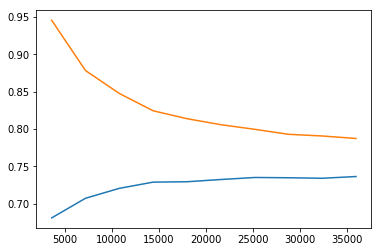

In [214]:
plt.plot(result[0], np.mean(result[2], axis=1))
plt.plot(result[0], np.mean(result[1], axis=1))

<font color='green'>На обучающих данных в количестве от 20000 и выше сходимость заметно уменьшается</font>

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [219]:
results = pd.DataFrame(index=range(3), columns=['type','result'])
# 1. все веса единицы
results.loc[0, 'type'] = 'ones'
results.loc[0, 'result'] = np.mean(cross_val_score(LogisticRegression(),
            data_train, train_y, cv=StratifiedShuffleSplit(3), scoring='roc_auc'))
# 2. веса пропорциональны частоте классов 
results.loc[1, 'type'] = 'balanced'
results.loc[1, 'result'] = np.mean(cross_val_score(LogisticRegression(class_weight='balanced'),
            data_train, train_y, cv=StratifiedShuffleSplit(3), scoring='roc_auc'))
# 3 рандомный выбор весов, просто, чтоб оценить качество модели при очевидно бессмысленном подходе
results.loc[2, 'type'] = 'random'
results.loc[2, 'result'] = np.mean(cross_val_score(LogisticRegression(),
    data_train, train_y, fit_params={'sample_weight': np.random.randn(data_train.shape[0])},
                        cv=StratifiedShuffleSplit(3), scoring='roc_auc'))
results

,type,result
0,ones,0.674952
1,balanced,0.68284
2,random,0.536049


<font color='green'>balanced выглядит разумным вариантом</font>

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

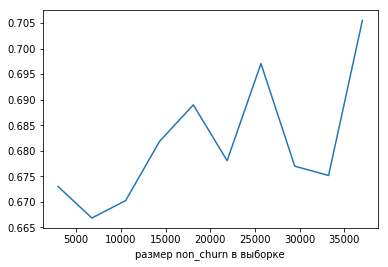

In [220]:
data = pd.concat([data_train, train_y], axis=1)
train_non_churn = data[data.y==-1]
train_churn = data[data.y==1]

results = pd.DataFrame(index=range(10), columns=['number', 'result'])

for ind,i in enumerate(np.linspace(train_churn.shape[0], train_non_churn.shape[0], 10)):
    idxes = np.random.choice(train_non_churn.index, int(i))
    undersampled = pd.concat([train_churn, train_non_churn.loc[idxes, :]], axis=0)
    result = np.mean(cross_val_score(LogisticRegression(), undersampled.drop(columns='y'), undersampled.y, scoring='roc_auc',
                   cv=StratifiedShuffleSplit(3)))
    results.loc[ind,'number'] = int(i)
    results.loc[ind,'result'] = result
plt.xlabel('размер non_churn в выборке')
plt.plot(results.number, results.result)

<font color='green'>Вцелом для логистической регрессии похоже, что размер обучающей выборки не так важен как равенство классов в этой выборке</font>

### <font color='green'>Третий и четвертый пункт были на предыдущей неделе, приведу необходимые этапы</font>

#### Первым делом создам функцию отсеивающую признаки, в которых не определен заданный процент значений

In [6]:

table_of_nan = pd.DataFrame(index = raw_data.columns, columns=['nans'])
for col in raw_data.columns:
    table_of_nan.loc[col,'nans'] = round((raw_data[col].isna().sum())/raw_data[col].shape[0]*100, 2)
table_of_nan.sort_values(by='nans', ascending=False, inplace=True)
table_of_nan.head(3)

,nans
Var52,100
Var141,100
Var55,100


In [7]:
def filter_attr(data, percentage):
    return data.loc[:,table_of_nan[table_of_nan.nans<percentage].index]

#### Выделим вещественные и категориальные данные из отфильтрованных данных для дальнейшей обработки

In [8]:
def type_processing(data):
    num_cols = []
    cat_cols = []
    for col in data.drop(columns=['ID','labels']).columns:
        if (int(str(col)[3:])<190):
            num_cols.append(col)
        else:
            cat_cols.append(col)
    return data.loc[:,num_cols], data.loc[:,cat_cols]

#### Начну с вещественных данных, к которым применю imputer с заданным типом наполнения Nan значений,  а затем стандартизирую

In [9]:
def num_processing(X_num, strategy):
    imp = Imputer(strategy=strategy, axis=0)
    X_num_imputed = imp.fit_transform(X_num)
    return pd.DataFrame(data=StandardScaler().fit_transform(X_num_imputed), index=X_num.index,
                         columns=X_num.columns)

#### К категориальным применю разные подходы

In [60]:
#таблица количества уникальных значений кат.признаков
number_of_unique = pd.DataFrame(index=raw_data.iloc[:,190:-1].columns, columns=['amount'])
for col in number_of_unique.index:
    number_of_unique.loc[col,'amount'] = raw_data.loc[:,col].unique().shape[0]
number_of_unique.sort_values(by='amount', inplace=True)
number_of_unique.head(3)

,amount
Var230,1
Var209,1
Var191,2


In [107]:
# В первом случае просто выкину все признаки у которых уникальных значений больше 10 
# и применю OneHotEncoding к оставшимся
def cat_1(X_cat):
    num_uni = number_of_unique.loc[X_cat.columns, :]
    return pd.get_dummies(X_cat.loc[:, num_uni[num_uni.amount<10].index])        


# Во втором - оставлю еще и те признаки,
# уникальных значений в которых меньше 50 и применю к ним LabelEncoder
def cat_2(X_cat):

    num_uni = number_of_unique.loc[X_cat.columns, :]
    X_cat_less_10 = pd.get_dummies(X_cat.loc[:, num_uni[num_uni.amount<10].index])
    X_cat_labelen = X_cat.loc[:, num_uni[50>num_uni.amount]
                              [num_uni.amount>=10].index].astype('str') \
                                    .apply(LabelEncoder().fit_transform)
    return pd.concat([X_cat_less_10, X_cat_labelen], axis=1)
  
# по умолчанию вобще никакой предобработки

#### Сборка всего вышеперечисленного

In [67]:
def assemble(data, percentage, strategy, num_of_cat_preprocessing=3):
    data = filter_attr(data, percentage)
    # ------------------------------------------
    X_num, X_cat = type_processing(data)
    X_num_pro = num_processing(X_num, strategy)
    X_cat_pro = X_cat.astype('category')

    if (num_of_cat_preprocessing==1):
        X_cat_pro = cat_1(X_cat)
    elif (num_of_cat_preprocessing==2):
        X_cat_pro = cat_2(X_cat)
        
    data_pro = pd.concat([X_cat_pro, X_num_pro, data.labels], axis=1)
    
    return data_pro

#### Функция для удобного теста 

In [69]:
def test(data, estimator, percentage, strategy='mean', num_of_cat_preprocessing=3):
    parameters = list(product(percentage, strategy, num_of_cat_preprocessing))
    results = pd.DataFrame(columns=['percentage', 'strategy', 'cat_processing', 'result'])
    for idx,param in enumerate(parameters):
        results.loc[idx, 'percentage'] = param[0]
        results.loc[idx, 'strategy'] = param[1]
        results.loc[idx, 'cat_processing'] = param[2]
        
        data_pro = assemble(data, param[0], param[1], param[2])
        results.loc[idx, 'result'] = np.mean(cross_val_score(estimator,
            data_pro.drop(columns='labels'), data_pro.labels, 
                cv=StratifiedShuffleSplit(3), scoring='roc_auc'))
    return results

#### <font color='green'>Под обработкой пропущенных значений я понимаю и удаление слишком разреженных признаков и заполнение Nan разными вариантами. Эстиматор все та же лучшая модель LightGBM из прошлой недели</font>

In [106]:
percentage = [75, 90, 98, 100]
strategy = ['mean', 'median', 'most_frequent']
cat_processing = [1, 2, 3]

In [108]:
warnings.simplefilter('ignore')
results = test(raw_data, clf, percentage, strategy, cat_processing)

In [120]:
temp = pd.DataFrame(index=range(10), columns=['parameter','mean'])
num=0
for i in percentage:
    temp.loc[num,'parameter'] = 'percentage: '+str(i)
    temp.loc[num,'mean'] = np.mean(results[results.percentage==i].result)
    num+=1
for i in strategy:
    temp.loc[num,'parameter'] = 'strategy: '+str(i)
    temp.loc[num,'mean'] = np.mean(results[results.strategy==i].result)
    num+=1
for i in cat_processing:
    temp.loc[num,'parameter'] = 'cat_processing: '+str(i)
    temp.loc[num,'mean'] = np.mean(results[results.cat_processing==i].result)
    num+=1

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [116]:
temp.iloc[:4]

,parameter,mean
0,percentage: 75,0.72235
1,percentage: 90,0.722996
2,percentage: 98,0.716987
3,percentage: 100,0.720451


<font color='green'>Как видим фильтрация признаков с большим кол-вом Nan значений практически не влияет на качество работы модели</font>

In [117]:
temp.iloc[4:7]

,parameter,mean
4,strategy: mean,0.729464
5,strategy: median,0.713941
6,strategy: most_frequent,0.718683


<font color='green'>А заполнение пропусков средним, которое идет по умолчанию в imputer, выглядит как разумный вариант</font>

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [119]:
temp.iloc[-3:]

,parameter,mean
7,cat_processing: 1,0.734916
8,cat_processing: 2,0.735507
9,cat_processing: 3,0.691665


<font color='green'>LabelEncoder в связке с OneHotEncoding дают лучший результат для LightGBM модели, а вариант оставлять категориальные признаки без обработки выдает сильно худшие показатели. </font>

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

<font color='green'>1)На случайном лесе это выглядит так</font>

In [171]:
clf_opt = ExtraTreesClassifier(n_estimators=50)
clf_opt.fit(data_train, train_y)
model = SelectFromModel(clf_opt, prefit=True)
X_new = model.transform(data_train)
X_new.shape

(40000, 56)

<font color='green'>2)Посмотрим, как отработает Lasso. При помощи параметра C настраиваем сколько признаков останется в матрице</font>

In [154]:
lsvc = LinearSVC(C=1., penalty="l1", dual=False).fit(data_train, train_y)
model = SelectFromModel(lsvc, prefit=True)

In [155]:
X_new = model.transform(data_train)
X_new.shape

(40000, 205)

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

In [157]:
param_grid ={
    'num_leaves': [15, 30],
    'reg_alpha': [0.01, 0.02],
    'min_data_in_leaf': [30, 50],
    'max_depth':[3, 5], 
    'silent':[True], 
    'metric':['auc'],                        
    'n_estimators':[100, 200],
    'colsample_bytree':[0.8],
    'subsample':[0.7],
    'learning_rate':[0.1, 0.2]
    }
fit_params = {
#             "early_stopping_rounds":[10] 
            "eval_metric" : 'auc', 
#             "eval_set" : [(test_X,test_y)],
            'eval_names': ['valid'],
            'verbose': 100,
            'feature_name': 'auto'
            }

In [173]:
gscv = GridSearchCV(clf, param_grid=param_grid, scoring='roc_auc', fit_params=fit_params, cv=StratifiedShuffleSplit(3))
data_pro = assemble(raw_data, 100, 'mean', 2)
gscv.fit(data_pro.drop(columns='labels'), data_pro.labels)
print(gscv.best_score_)
gscv.best_params_

C:\Users\preductor\AppData\Local\conda\conda\envs\py3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


0.7337076397424696


{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 3,
 'metric': 'auc',
 'min_data_in_leaf': 50,
 'n_estimators': 100,
 'num_leaves': 15,
 'reg_alpha': 0.01,
 'silent': True,
 'subsample': 0.7}

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

<font color='green'>LightGBM имеет встроенную функцию feature_importances_ </font>

In [162]:
importances = pd.DataFrame(index=range(data_train.shape[1]), columns=['feature','importance'])
clf.fit(data_train, train_y)
importances.importance = clf.feature_importances_
importances.feature = data_train.columns
importances.sort_values(by='importance', ascending=False, inplace=True)

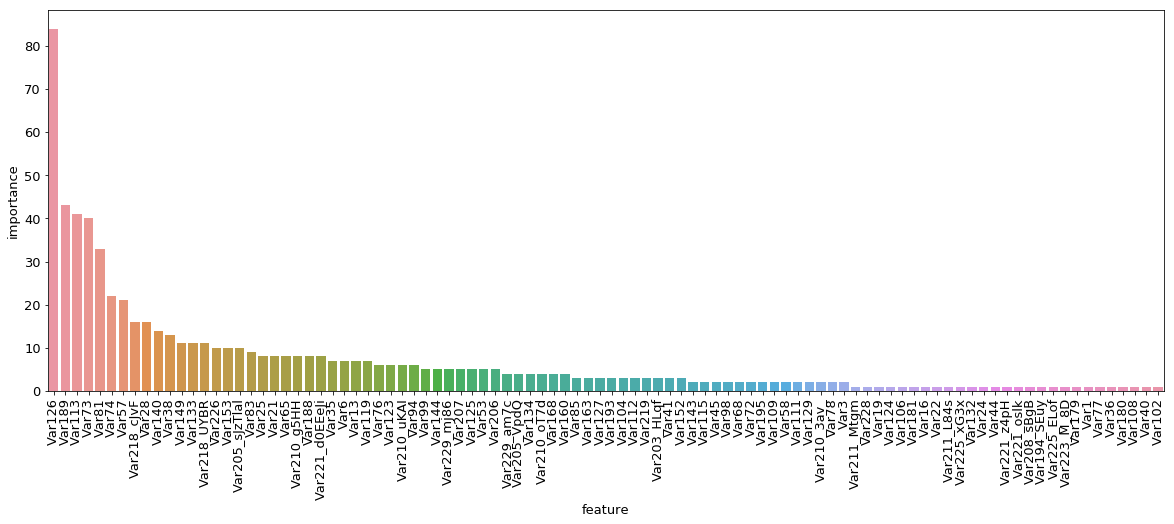

In [144]:
plt.figure(figsize=(20,7))
plt.rcParams.update({'font.size': 13})
plt.xticks(rotation='vertical')
sns.barplot(x='feature', y='importance', data=importances[importances.importance>0])

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

In [181]:
best_model = gscv.best_estimator_
proba = best_model.predict_proba(data_pro.drop(columns='labels'))
proba_data = pd.DataFrame(index=range(data_pro.shape[0]),columns=['prob_1','prob_target','labels'])
proba_data.prob_1 = np.squeeze(proba.T[0])
proba_data.prob_target = np.squeeze(proba.T[1])
proba_data.labels = data_pro.labels

In [198]:
# самая большая ошибка первого рода
temp_1 = proba_data[proba_data.labels==1]
temp_1.sort_values(by='prob_target').head(3)

,prob_1,prob_target,labels
4309,0.991292,0.008708,1
29190,0.991058,0.008942,1
15321,0.990526,0.009474,1


<font color='green'>Выведем три с самой большой ошибкой и три с минимальной</font>

In [201]:
raw_data.loc[temp_1.sort_values(by='prob_target').index[:3].append(temp_1.sort_values(by='prob_target', ascending=False).index[:3]), :]

,ID,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,labels
4309,4309,NaN,NaN,NaN,NaN,NaN,1246.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,ELof,Xa3G,ZI9m,TCU50_Yjmm6GIBZ0lL_,am7c,NaN,1
29190,29190,NaN,NaN,NaN,NaN,NaN,1253.0,21.0,NaN,NaN,...,P6pu4Vl,LM8l689qOp,NaN,ELof,453m,ZI9m,R4y5gQQWY8OodqDV,am7c,NaN,1
15321,15321,NaN,NaN,NaN,NaN,NaN,553.0,7.0,NaN,NaN,...,APgdzOv,LM8l689qOp,NaN,xG3x,fKCe,6fzt,Zy3gnGM,am7c,NaN,1
26798,26798,NaN,NaN,NaN,NaN,NaN,413.0,7.0,NaN,NaN,...,X86AgOW,LM8l689qOp,NaN,NaN,3Cy4,RAYp,F2FyR07IdsN7I,NaN,NaN,1
9806,9806,NaN,NaN,NaN,NaN,NaN,1365.0,7.0,NaN,NaN,...,PyFH7Cg,LM8l689qOp,NaN,NaN,7P5s,RAYp,F2FyR07IdsN7I,NaN,NaN,1
38041,38041,NaN,NaN,NaN,NaN,NaN,504.0,0.0,NaN,NaN,...,yOuy5oW,LM8l689qOp,NaN,NaN,453m,RAYp,F2FyR07IdsN7I,NaN,NaN,1


In [199]:
# самая большая ошибка второго рода
temp_2 = proba_data[proba_data.labels==-1]
temp_2.sort_values(by='prob_target', ascending=False).head(3)

,prob_1,prob_target,labels
35441,0.483609,0.516391,-1
22640,0.488298,0.511702,-1
9118,0.502943,0.497057,-1


<font color='green'>Выведем три с самой большой ошибкой и три с минимальной</font>

In [202]:
raw_data.loc[temp_2.sort_values(by='prob_target', ascending=False).index[:3].append(temp_2.sort_values(by='prob_target').index[:3]), :]

,ID,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,labels
35441,35441,NaN,NaN,NaN,NaN,NaN,826.0,0.0,NaN,NaN,...,93cqqb8,LM8l689qOp,NaN,NaN,Aoh3,RAYp,F2FyR07IdsN7I,NaN,NaN,-1
22640,22640,NaN,NaN,NaN,NaN,NaN,602.0,0.0,NaN,NaN,...,hW4EVJ2,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,-1
9118,9118,NaN,NaN,NaN,NaN,NaN,175.0,0.0,NaN,NaN,...,QkgQQMs,LM8l689qOp,NaN,NaN,453m,RAYp,F2FyR07IdsN7I,NaN,NaN,-1
26933,26933,NaN,NaN,NaN,NaN,NaN,1008.0,7.0,NaN,NaN,...,Xlg7e4L,LM8l689qOp,NaN,ELof,kwS7,6fzt,4rd_,am7c,NaN,-1
4269,4269,NaN,NaN,NaN,NaN,NaN,532.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,kG3k,Xa3G,ZI9m,ib5G6X1eUxUn6,NaN,NaN,-1
15563,15563,NaN,NaN,NaN,NaN,NaN,70.0,7.0,NaN,NaN,...,yUzqFbB,LM8l689qOp,NaN,kG3k,Qu4f,RAYp,F2FyR07IdsN7I,mj86,NaN,-1


<font color='green'>Не представляю почему LightGBM так решил, это же не линейная модель, чтобы можно было интуитивно понять что к чему</font>

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

In [203]:
gscv.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        importance_type='split', learning_rate=0.1, max_depth=3,
        metric='auc', min_child_samples=20, min_child_weight=0.001,
        min_data_in_leaf=50, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=15, objective=None, random_state=None,
        reg_alpha=0.01, reg_lambda=0.0, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=0)

<font color='green'>Берем все признаки, кроме 100%Nan, пропуски заполняем mean, к категориальным признакам до 10 уникальных значений применяем OneHotEncoding, до 50 значений - LabelEncoder</font>

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

<font color='green'>Собрать больше данных</font>